# Football Forecasting - WDSS Demo [ Tidy Version ]

Here we provide a baseline model for our upcoming Premier League forecasting competition.

In [1]:
# Import some modules
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

In [2]:
# Import some more modules...
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Data

In [4]:
# Define a function to quickly get data from any given EPL season.
# N.B: Current GW fixtures are only added after the GW has finished.

def get_epl_data(season):
    """
    Takes in season formatted as YYYY (last 2 digits of Y1 and Y2 - no spaces or slashes)
    """
    x = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + str(season) + "/E0.csv") # input season year within hyperlink
    
    x = x[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']] # isolate required columns
    x = x.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR':'Result'})
    globals()["epl_"+str(season)] = x
    
    return globals()["epl_"+str(season)]

In [5]:
# Get data from the 2018/2019 season
# Consider COVID19's impact on home crowds and the home advantage - we will start with 18/19 instead
get_epl_data(1819)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result
0,Man United,Leicester,2,1,H
1,Bournemouth,Cardiff,2,0,H
2,Fulham,Crystal Palace,0,2,A
3,Huddersfield,Chelsea,0,3,A
4,Newcastle,Tottenham,1,2,A
...,...,...,...,...,...
375,Liverpool,Wolves,2,0,H
376,Man United,Cardiff,0,2,A
377,Southampton,Huddersfield,1,1,D
378,Tottenham,Everton,2,2,D


### Model

In [5]:
# Remove final week of fixtures
# Notice the home advantage
epl_1819 = epl_1819[:-10]
epl_1819.mean()

HomeGoals    1.575676
AwayGoals    1.224324
dtype: float64

In [6]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1819.mean()[0],  epl_1819.mean()[1])

0.24840693651483478

In [7]:
# Prepare the dataset
# Separate home and away teams/goals - then concatenate
goal_model_data = pd.concat([epl_1819[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1819[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [8]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [9]:
# Get a statistical summary of the poisson model
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1030.1
Date:                Mon, 27 Sep 2021   Deviance:                       732.30
Time:                        00:45:45   Pearson chi2:                     634.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4925      0.192      2.572      0.010       0.117       0.868
team[T.Bournemouth]           -0.2703      0.183     -1.481      0.139      -0.628       0.087
team[T.Brighton]              -0.7334      0.209     -3.503      0.000      -1.144      -0.323
team[T.Burnley]               -0.4493      0.192     -2.334      0.020      -0.827      -0.072
team[T.Cardiff]               -0.7702      0.214     -3.603      0.000      -1.189      -0.351
team[T.Chelsea]               -0.1249      0.174     -0.718      0.473      -0.466       0.216
team[T.Crystal Palace]        -0.4125      0.190     -2.169      0.030      -0.785      -0.040
team[T.Everton]               -0.3165      0.183     -1.726      0.084      -0.676       0.043
team[T.Fulham]                -0.6986      0.209     -3.335      0.001      -1.109      -0.288
team[T.Huddersfield]          -1.1820      0.249     -4.744      0.000      -1.670      -0.694
team[T.Leicester]             -0.3261      0.184     -1.768      0.077      -0.688       0.035
team[T.Liverpool]              0.1849      0.161      1.149      0.251      -0.130       0.500
team[T.Man City]               0.2291      0.159      1.438      0.150      -0.083       0.541
team[T.Man United]            -0.0621      0.173     -0.360      0.719      -0.401       0.276
team[T.Newcastle]             -0.6104      0.202     -3.024      0.002      -1.006      -0.215
team[T.Southampton]           -0.4387      0.193     -2.275      0.023      -0.817      -0.061
team[T.Tottenham]             -0.0917      0.173     -0.531      0.595      -0.430       0.247
team[T.Watford]               -0.3106      0.185     -1.683      0.092      -0.672       0.051
team[T.West Ham]              -0.3788      0.188     -2.017      0.044      -0.747      -0.011
team[T.Wolves]                -0.4239      0.189     -2.244      0.025      -0.794      -0.054
opponent[T.Bournemouth]        0.2458      0.189      1.303      0.192      -0.124       0.615
opponent[T.Brighton]           0.0890      0.195      0.456      0.648      -0.293       0.471
opponent[T.Burnley]            0.2413      0.188      1.282      0.200      -0.128       0.610
opponent[T.Cardiff]            0.2950      0.186      1.585      0.113      -0.070       0.660
opponent[T.Chelsea]           -0.2537      0.214     -1.185      0.236      -0.673       0.166
opponent[T.Crystal Palace]    -0.0269      0.200     -0.134      0.893      -0.420       0.366
opponent[T.Everton]           -0.1366      0.207     -0.659      0.510      -0.543       0.269
opponent[T.Fulham]             0.3861      0.182      2.121      0.034       0.029       0.743
opponent[T.Huddersfield]       0.3551      0.183      1.941      0.052      -0.003       0.714
opponent[T.Leicester]         -0.0595      

### Simulation & Validation

In [10]:
# Build a function to simulate a match using the newly generated poisson model
# Outputs the probability distribution 
# Considers 8 goals as a maximum for either team

def simulate_match(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


simulate_match('Chelsea', 'Man City')

array([[8.84524074e-02, 1.41227448e-01, 1.12745332e-01, 6.00049071e-02,
        2.39516937e-02, 7.64848957e-03, 2.03532554e-03, 4.64242926e-04,
        9.26541255e-05],
       [7.32953480e-02, 1.17026944e-01, 9.34254767e-02, 4.97225646e-02,
        1.98473708e-02, 6.33785694e-03, 1.68655549e-03, 3.84691020e-04,
        7.67770666e-05],
       [3.03677887e-02, 4.84866995e-02, 3.87081201e-02, 2.06010938e-02,
        8.22317894e-03, 2.62590609e-03, 6.98775055e-04, 1.59385499e-04,
        3.18103372e-05],
       [8.38800475e-03, 1.33926994e-02, 1.06917200e-02, 5.69030804e-03,
        2.27135616e-03, 7.25311709e-04, 1.93011369e-04, 4.40244871e-05,
        8.78645666e-06],
       [1.73766250e-03, 2.77443710e-03, 2.21490111e-03, 1.17880655e-03,
        4.70535074e-04, 1.50255871e-04, 3.99843144e-05, 9.12013080e-06,
        1.82020597e-06],
       [2.87979901e-04, 4.59802822e-04, 3.67071858e-04, 1.95361638e-04,
        7.79809911e-05, 2.49016543e-05, 6.62653357e-06, 1.51146403e-06,
        3.0

In [11]:
# Similar function, selecting most probable scoreline

def simulate_match_output(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # multiply distributions together
    
    # Get most likely score from the matrix
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    output = homeTeam + ": " + str(h) + "\n" + awayTeam + ": " + str(a)
    
    return print(output)
    return(h, a)

simulate_match_output('Chelsea', 'Man City')

Chelsea: 0
Man City: 1


In [12]:
# Similar function, built to be iterated

def simulate_match_clean(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # *multiply distributions together
    
    # Get most likely score
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    
    return(h, a)

simulate_match_clean('Chelsea', 'Man City')

(0, 1)

In [42]:
# Simulate matches for any given PL seaason
# Takes in dataset as input

def simulate_test(x):
    
    data = x.copy()
    
    data['HomePred'] = [0] * len(data)
    data['AwayPred'] = [0] * len(data)
    
    for i in range(len(data)):
        homeTeam = data['HomeTeam'][i]
        awayTeam = data['AwayTeam'][i]
        
        simulate_match_clean(homeTeam, awayTeam)
        data.loc[i, 'HomePred'] = int(h)
        data.loc[i, 'AwayPred'] = int(a)
    
    data = pd.DataFrame.from_dict(data)
    
    return(data)

epl_1819_post = simulate_test(epl_1819)
epl_1819_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred
0,Man United,Leicester,2,1,H,1,1
1,Bournemouth,Cardiff,2,0,H,2,0
2,Fulham,Crystal Palace,0,2,A,1,1
3,Huddersfield,Chelsea,0,3,A,0,2
4,Newcastle,Tottenham,1,2,A,0,1
...,...,...,...,...,...,...,...
365,Wolves,Fulham,1,0,H,2,0
366,Arsenal,Brighton,1,1,D,2,0
367,Chelsea,Watford,3,0,H,1,0
368,Huddersfield,Man United,1,1,D,0,2


In [14]:
type(epl_1819_post['AwayPred'][2])

numpy.int64

In [15]:
# Add prediction results column
# NOT WORKING - Does not register draws

def update_df_res(data):
    
    ResultPred = []
    
    for i in data['HomePred']:
        if i == data['AwayPred'][i]:
            ResultPred.append('D')
        elif i < data['AwayPred'][i]:
            ResultPred.append('A')
        else:
            ResultPred.append('H')
        
    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename({0: 'ResultPred'}, axis =1)
    
    return data

In [16]:
# Validate full time result prediction

def update_df_ftr(data):    
    
    correctFTR = []
    
    for i in range(len(data)):
        if str(data['ResultPred'][i]) is str(data['Result'][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)
        
    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename({0: 'correctFTR'}, axis =1)
    
    return data

In [24]:
# Vallidate Scoreline Prediction

def update_df_correct(data):    
    
    correctScore = []

    for i in range(len(data)):
        if data['HomeGoals'][i] == data['HomePred'][i] and data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append(True)
        elif data['HomeGoals'][i] == data['HomePred'][i]:
            correctScore.append('Home')
        elif data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append('Away')
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename({0: 'correctScore'}, axis =1)
    
    return data

In [44]:
update_df_result(epl_1819_post)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,ResultPred
0,Man United,Leicester,2,1,H,1,1,D
1,Bournemouth,Cardiff,2,0,H,2,0,H
2,Fulham,Crystal Palace,0,2,A,1,1,D
3,Huddersfield,Chelsea,0,3,A,0,2,A
4,Newcastle,Tottenham,1,2,A,0,1,A
...,...,...,...,...,...,...,...,...
365,Wolves,Fulham,1,0,H,2,0,H
366,Arsenal,Brighton,1,1,D,2,0,H
367,Chelsea,Watford,3,0,H,1,0,H
368,Huddersfield,Man United,1,1,D,0,2,A


In [46]:
epl_1819_post = update_df_correct(epl_1819_post)
epl_1819_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,ResultPred,correctScore,correctScore
0,Man United,Leicester,2,1,H,1,1,D,Away,Away
1,Bournemouth,Cardiff,2,0,H,2,0,H,True,True
2,Fulham,Crystal Palace,0,2,A,1,1,D,False,False
3,Huddersfield,Chelsea,0,3,A,0,2,A,Home,Home
4,Newcastle,Tottenham,1,2,A,0,1,A,False,False
...,...,...,...,...,...,...,...,...,...,...
365,Wolves,Fulham,1,0,H,2,0,H,Away,Away
366,Arsenal,Brighton,1,1,D,2,0,H,False,False
367,Chelsea,Watford,3,0,H,1,0,H,Away,Away
368,Huddersfield,Man United,1,1,D,0,2,A,False,False


In [43]:
epl_1819_post.columns

Index(['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'Result', 'HomePred',
       'AwayPred'],
      dtype='object')

In [87]:
epl_1819_post['HomeTeam'].unique()

array(['Man United', 'Bournemouth', 'Fulham', 'Huddersfield', 'Newcastle',
       'Watford', 'Wolves', 'Arsenal', 'Liverpool', 'Southampton',
       'Cardiff', 'Chelsea', 'Everton', 'Leicester', 'Tottenham',
       'West Ham', 'Brighton', 'Burnley', 'Man City', 'Crystal Palace'],
      dtype=object)

In [ ]:
# Add validation columns
# NOT WORKING - Does not take into account draws

def update_df(data):
    
    ResultPred = []
    
    for i in data['HomePred']:
        if int(i) > int(data['AwayPred'][i]):
            ResultPred.append('H')
        elif int(i) == int(data['AwayPred'][i]):
            ResultPred.append('D')
        else:
            ResultPred.append('A')
        
    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename({0: 'ResultPred'}, axis =1)
    
    correctFTR = []
    
    for i in range(len(data)):
        if str(data['ResultPred'][i]) is str(data['Result'][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)
        
    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename({0: 'correctFTR'}, axis =1)
    
    correctScore = []

    for i in range(len(data)):
        if data['HomeGoals'][i] == data['HomePred'][i] and data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append(True)
        elif data['HomeGoals'][i] == data['HomePred'][i]:
            correctScore.append('Home')
        elif data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append('Away')
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename({0: 'correctScore'}, axis =1)
    
    return data

#epl_1819_post = update_df(epl_1819_post)

In [54]:
# Total correct final outcomes
epl_1819_post['ResultPred'].value_counts()

H    148
D    141
A     81
Name: ResultPred, dtype: int64

In [53]:
# At least one correct prediction (home, away or both)
sum(epl_1819_post['correctScore'].value_counts()[-3:])

ValueError: Grouper for 'correctScore' not 1-dimensional

In [ ]:
# Most common incorrect predictions (Draws seem prety common here?!)
#epl_1819_post2 = epl_1819_post[epl_1819_post['correctFTR'] == False]
#epl_1819_post2['ResultPred'].value_counts()

# WILL NOT WORK UNTIL DRAWS ARE ACCOUNTED FOR

### Plots

In [ ]:
chelsea_mancity = simulate_match('Chelsea', 'Man City')

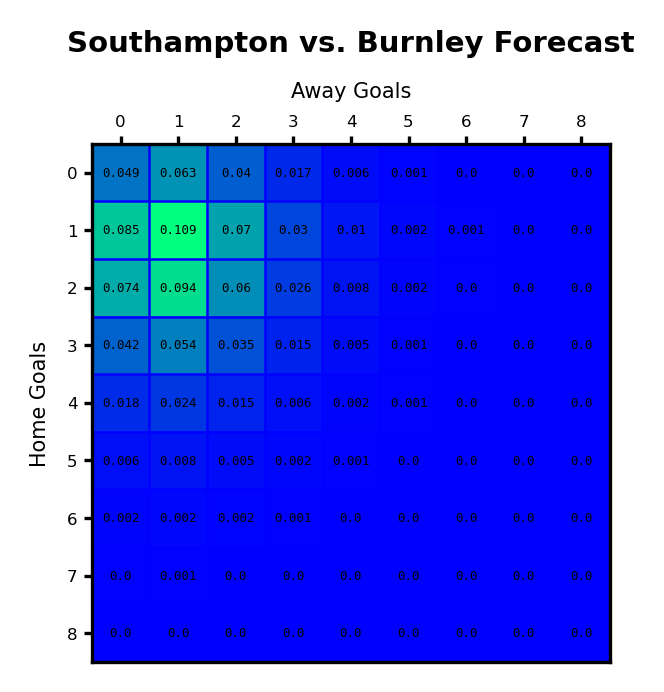

In [55]:
def goal_matrix(homeTeam, awayTeam):
    
    x = simulate_match(homeTeam, awayTeam)
    
    # *Match the plotting functions to the max goals
    # Axes labels
    goals = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    # Plot figure
    fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
    fig.tight_layout()
    im = ax.imshow(x, cmap="winter")

    # Add grid
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='minor', color='w', length=0)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=0.6)  

    # Set ticks and paremeters
    ax.set_yticks(np.arange(len(goals)))
    ax.set_yticklabels(goals, fontsize=4)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(goals)))
    ax.set_xticklabels(goals, fontsize=4)

    ax.tick_params(axis='both', which='major', length=2, pad=1.5)

    ax.set_ylabel('Home Goals', fontsize=5) # axes label (y)
    ax.set_xlabel('Away Goals', fontsize=5)
    ax.xaxis.set_label_position('top')

    # * Set this to the Home vs Away teams
    ax.set_title(str(homeTeam) + " vs. " + str(awayTeam) + " Forecast",
                 fontsize=7, y=1.13, weight='bold')

    # *rename this variable
    # Rounding probabilites to add to the plot
    rounded = x.tolist()
    rounded3 = []
    for z in rounded:
        rounded2 = [round(x, 3) for x in z]
        rounded3.append(rounded2)
    rounded3 = np.array(rounded3)

    for i in range(len(goals)):
        for j in range(len(goals)):
            text = ax.text(j, i, rounded3[i, j],
                           ha="center", va="center", color="black", fontsize=3,
                           fontfamily='monospace')

    plt.show()
    
    
goal_matrix('Southampton', 'Burnley')

In [56]:
# Define a function to get the seasons fixtures from csv
def get_epl_fixtures(season):
    """
    Takes in season formatted as YYYY (First Year of the season)
    """
    #x = pd.read_csv("https://fixturedownload.com/download/csv/epl-" + str(season)) # input season year within hyperlink
    x = pd.read_csv("https://fixturedownload.com/download/epl-" +str(season) + "-GMTStandardTime.csv") # input season year within hyperlink
    
    x = x[['Round Number','Home Team','Away Team','Result', 'Date']] # isolate required columns
    x = x.rename(columns={'Round Number': 'GW', 'Home Team': 'HomeTeam', 'Away Team':'AwayTeam'})
    globals()["epl_fixtures_"+str(season)] = x
    
    return globals()["epl_fixtures_"+str(season)]

In [57]:
get_epl_fixtures(2021)

,GW,HomeTeam,AwayTeam,Result,Date
0,1,Brentford,Arsenal,2 - 0,13/08/2021 20:00
1,1,Man Utd,Leeds,5 - 1,14/08/2021 12:30
2,1,Burnley,Brighton,1 - 2,14/08/2021 15:00
3,1,Chelsea,Crystal Palace,3 - 0,14/08/2021 15:00
4,1,Everton,Southampton,3 - 1,14/08/2021 15:00
...,...,...,...,...,...
375,38,Crystal Palace,Man Utd,NaN,22/05/2022 16:00
376,38,Leicester,Southampton,NaN,22/05/2022 16:00
377,38,Liverpool,Wolves,NaN,22/05/2022 16:00
378,38,Man City,Aston Villa,NaN,22/05/2022 16:00


In [88]:
get_epl_data(2122)
epl_2122['HomeTeam'].unique()

array(['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham'],
      dtype=object)

In [90]:
epl_fixtures_2021['HomeTeam'].unique()

array(['Brentford', 'Man Utd', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Spurs',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham'],
      dtype=object)

In [58]:
# Get this weeks fixtures
epl_fixtures_2021[50:60][:]

,GW,HomeTeam,AwayTeam,Result,Date
50,6,Chelsea,Man City,0 - 1,25/09/2021 12:30
51,6,Man Utd,Aston Villa,0 - 1,25/09/2021 12:30
52,6,Everton,Norwich,2 - 0,25/09/2021 15:00
53,6,Leeds,West Ham,1 - 2,25/09/2021 15:00
54,6,Leicester,Burnley,2 - 2,25/09/2021 15:00
55,6,Watford,Newcastle,1 - 1,25/09/2021 15:00
56,6,Brentford,Liverpool,3 - 3,25/09/2021 17:30
57,6,Southampton,Wolves,NaN,26/09/2021 14:00
58,6,Arsenal,Spurs,NaN,26/09/2021 16:30
59,6,Crystal Palace,Brighton,NaN,27/09/2021 20:00


#### Season Standings

https://www.rotowire.com//soccer/tables/standings.php?league=EPL&length=total&season=2019

https://www.rotowire.com/soccer/league-table.php?season=2018

In [ ]:
def multiplpot

In [78]:
game_week = epl_fixtures_2021[50:60][:][['HomeTeam', 'AwayTeam']].reset_index()
game_week

,index,HomeTeam,AwayTeam
0,50,Chelsea,Man City
1,51,Man Utd,Aston Villa
2,52,Everton,Norwich
3,53,Leeds,West Ham
4,54,Leicester,Burnley
5,55,Watford,Newcastle
6,56,Brentford,Liverpool
7,57,Southampton,Wolves
8,58,Arsenal,Spurs
9,59,Crystal Palace,Brighton


In [81]:
game_week['HomeTeam'][0]

'Chelsea'

In [83]:
# Edit the names


for i in range(0, len(game_week)):
    x = simulate_match(game_week['HomeTeam'][i], game_week['AwayTeam'][i])
    
    

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error converting data to categorical: observation with value 'Man Utd' does not match any of the expected levels (expected: ['Arsenal', 'Bournemouth', ..., 'West Ham', 'Wolves'])
    goals ~ home + team + opponent
                   ^^^^

NameError: name 'homeTeam' is not defined

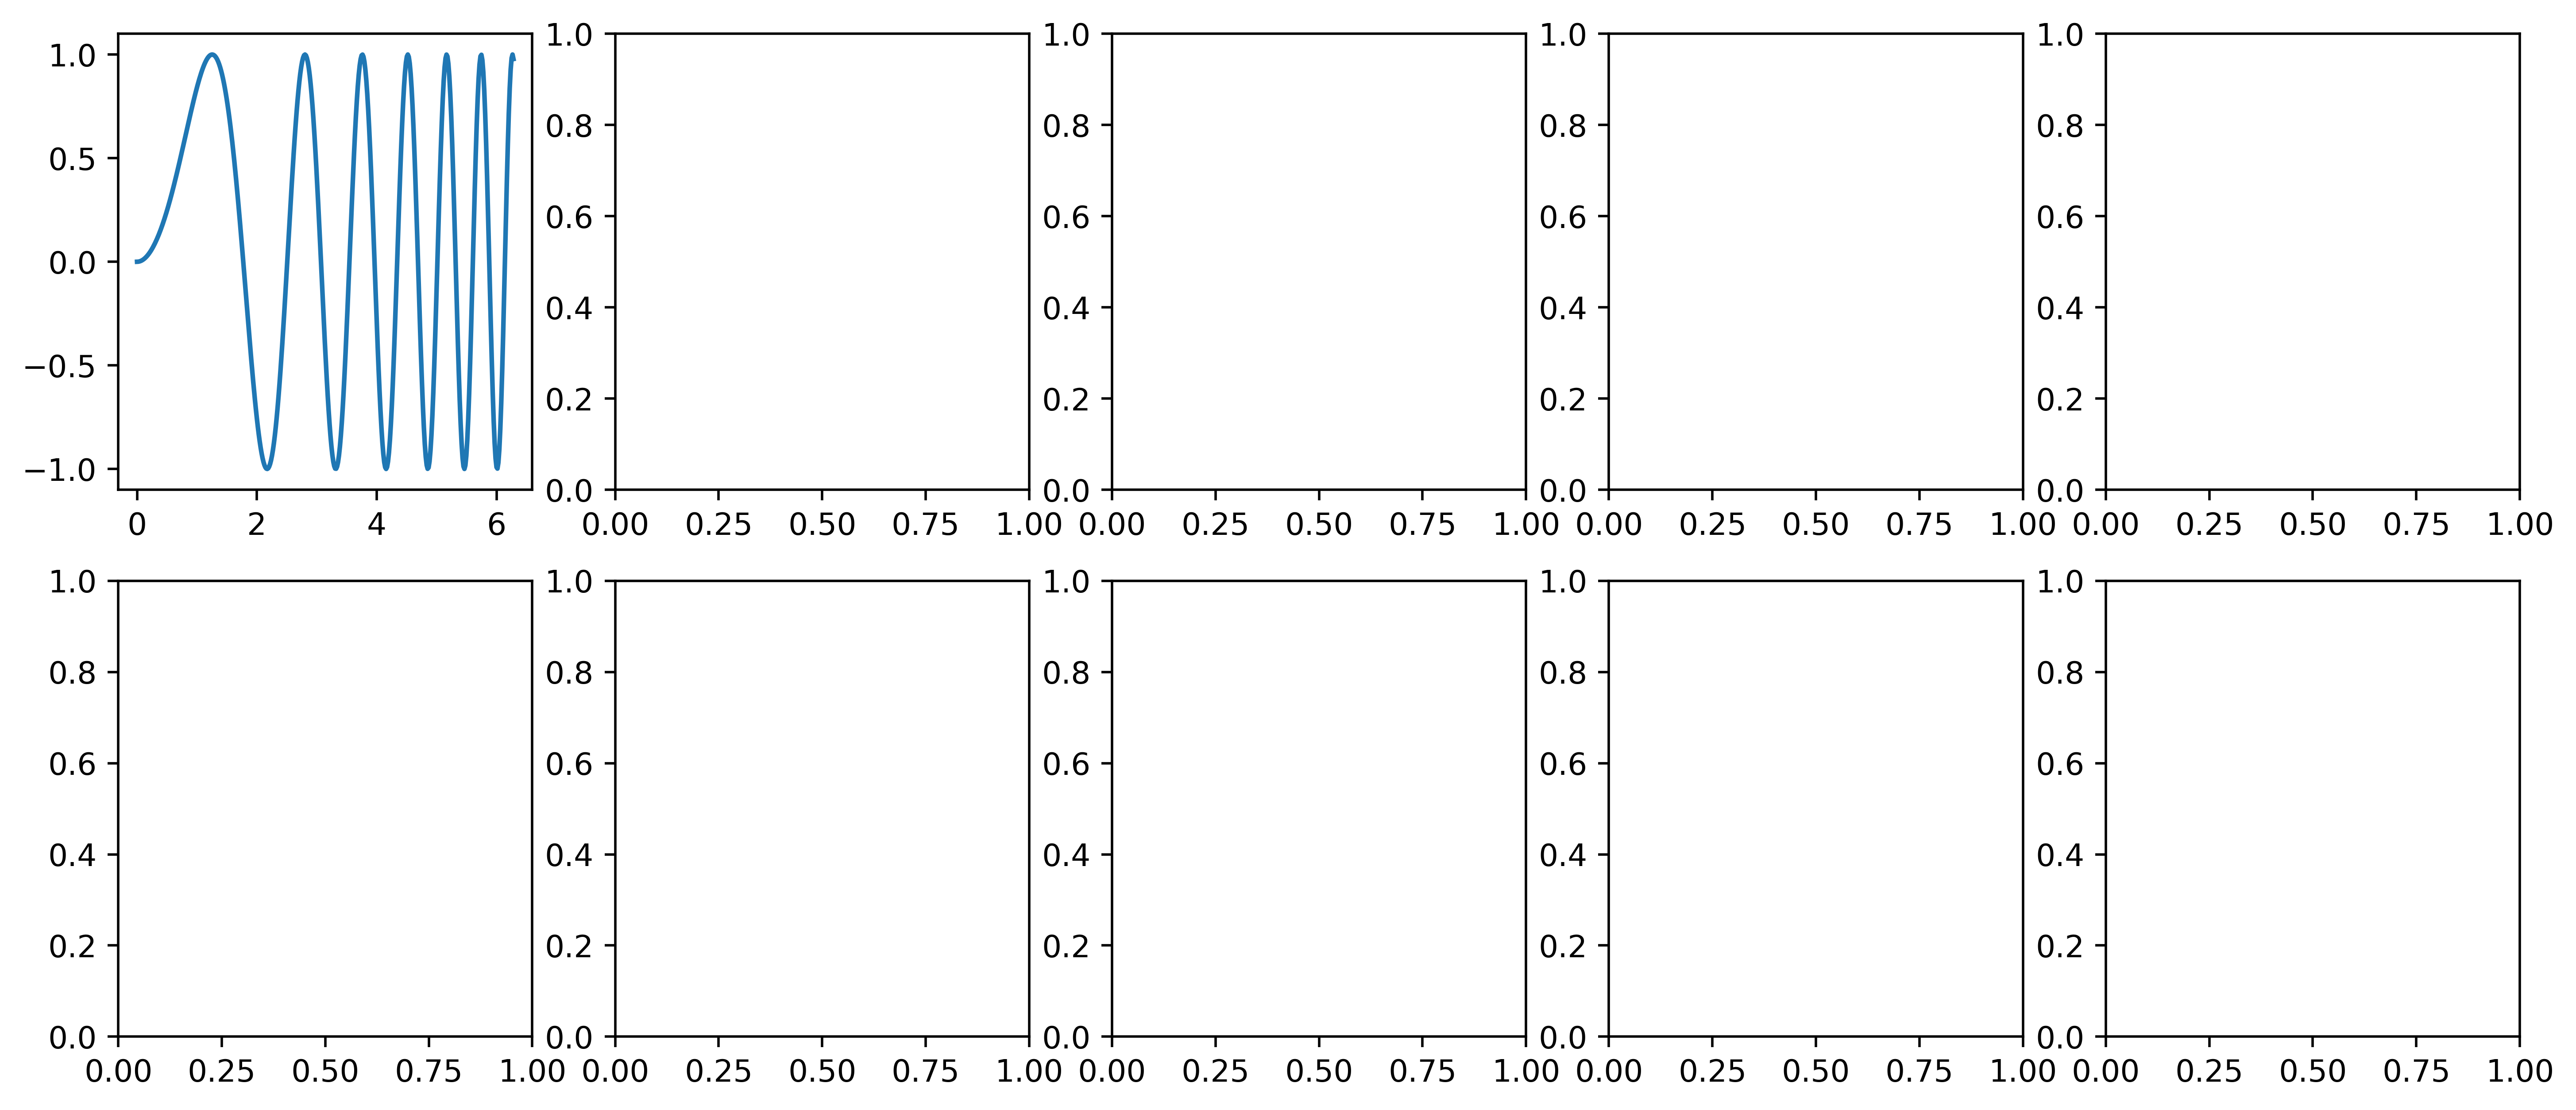

In [64]:


# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)


fig, axs = plt.subplots(2, 5, figsize=(14,6), dpi=500)
axs[0, 0].plot(x, y)
axs[0, 0].set_title(str(homeTeam) + " vs. " + str(awayTeam) + " Forecast",
                 fontsize=7, y=1.13, weight='bold')

axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')


axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')

axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Next Steps

Build on the baseline.

Participate in the competition.